In [ ]:
!pip install torch===1.6.0 torchvision===0.7.0 -f https://download.pytorch.org/whl/torch_stable.html
!pip install sklearn

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import torchvision
import torchvision.transforms as transforms

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Assuming that we are on a CUDA machine, this should print a CUDA device:

print(device)

cuda:0


In [3]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4, shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4, shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


torch.Size([4, 3, 32, 32])


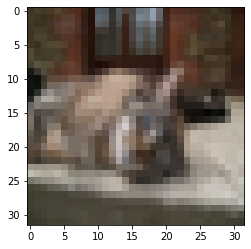

In [7]:
trainset[0][0].shape
for i, labels in trainloader :
  print(i.shape)
  imshow(i[3]) # Le trainloader est découpé en batch de taille 4
  break

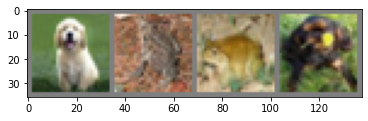

  dog  frog  frog   dog


In [6]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [8]:
class CNN(nn.Module):
    def __init__(self):
      super().__init__()
      self.conv1 = nn.Conv2d(3, 64, 3)  # 3 channels en entrée (couches 2d)  64 channels en sortie  et kernels de 3par3
      self.pool = nn.MaxPool2d(2, 2)  # Utilisée 2 fois, réduction dimensionnelle. Chaque carrée de 2x2 sera remplacé par 1 pixel (le max des 4)
      self.conv2 = nn.Conv2d(64, 128, 4)  # 2e convulution, on passe de 64 channels à 128 et les kernels sont de 4par4
                                          # Ici il y a un deuxième pooling. On a arrive à du 6 par 6 par 128
      self.fc1 = nn.Linear(128 * 6 * 6, 256)  # On passe en full connected, juste des couches denses classiques.
      self.fc2 = nn.Linear(256, 128)  # Pareil
      self.fc3 = nn.Linear(128, 10)   # On termine sur nos 10 neurones de sortie.

    def forward(self, x): # Sert à faire passer une donnée dans le réseau.
      x = self.conv1(x)
      x = torch.relu(x) # Fonction d'activation
      x = self.pool(x) # Après le pooling, pas de fonction d'activation.
      x = self.conv2(x)
      x = torch.relu(x)
      x = self.pool(x)
      x = x.view(x.shape[0], -1)
      x = self.fc1(x)
      x = torch.relu(x)
      x = self.fc2(x)
      x = torch.relu(x)
      x = self.fc3(x)
      return x

In [9]:
import torch.optim as optim

In [10]:
net = CNN()

In [ ]:
net.to(device)  # Pour gpu

CNN(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(64, 128, kernel_size=(4, 4), stride=(1, 1))
  (fc1): Linear(in_features=4608, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=10, bias=True)
)

In [ ]:
criterion = nn.CrossEntropyLoss()  # Elle fonctionne bien dans la classification non binaire.
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)  # Pour la backprop. Il est déjà connecté aux paramètres du network

In [ ]:
for epoch in range(4):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data[0].to(device), data[1].to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs) # Un forward
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

print('Finished Training')

[1,  2000] loss: 2.032
[1,  4000] loss: 1.642
[1,  6000] loss: 1.466
[1,  8000] loss: 1.379
[1, 10000] loss: 1.266
[1, 12000] loss: 1.204
[2,  2000] loss: 1.077
[2,  4000] loss: 1.035
[2,  6000] loss: 0.998
[2,  8000] loss: 0.974
[2, 10000] loss: 0.942
[2, 12000] loss: 0.917
[3,  2000] loss: 0.800
[3,  4000] loss: 0.778
[3,  6000] loss: 0.772
[3,  8000] loss: 0.765
[3, 10000] loss: 0.769
[3, 12000] loss: 0.750
[4,  2000] loss: 0.594
[4,  4000] loss: 0.595
[4,  6000] loss: 0.609
[4,  8000] loss: 0.611
[4, 10000] loss: 0.616
[4, 12000] loss: 0.624
Finished Training


In [11]:
PATH = './cifar_net.pth'


In [ ]:
torch.save(net.state_dict(), PATH)

In [15]:
net = CNN()
net.load_state_dict(torch.load(PATH))

<All keys matched successfully>

In [16]:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 74 %


Essayons de voir la prédiction sur le 100e element

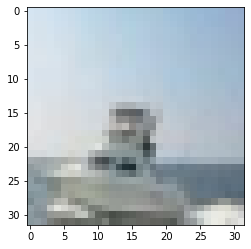

In [17]:
N = 100
imshow(trainset[N][0])

## **PGD ATTACK**

Aucune idée de comment faire pour l'instant. Comment on est censé trouver la perturbation ?? Il faut forcément connaitre le gradient de la loss et donc certainement le calculer avec le jeu de train ??

In [22]:
def PGD(batch, net, iterations, lr=2/225, eps=8/255):

  images, labels = batch[0].to(device), batch[1].to(device)
  criterion = nn.CrossEntropyLoss()
  
  delta = torch.zeros(images.shape).requires_grad_(True).to(device)

  #optimizer = optim.SGD(delta, lr=0.001)


  #optimizer.zero_grad()

  for i in range(iterations):
    perturbed_images = images + delta
    predictions = net(perturbed_images)
    loss = criterion(predictions, labels)
    loss.backward()

    delta.data = (delta + lr*torch.sign(delta.grad.data)).clamp(-eps,eps)
    
    delta.grad.zero_()
    #optimizer.step()
  return x + delta, delta

In [23]:
# tester la fonction PGD sur un batch
dataiter = iter(trainloader)

data = dataiter.next()

images = PGD(data, net, 10, lr=0.001)

RuntimeError: ignored

In [28]:
def pgd_attack(model_cnn, device, X_batch, y_batch, loss_model, nb_it, eta=2/255, epsilon=8/255):

  delta = torch.zeros_like(X_batch).to(device).requires_grad_(True)

  X_att = X_batch.to(device) + delta

 

  for it in range(nb_it):
    loss = loss_model(model_cnn(X_att), y_batch)

    loss.backward()
    delta.data = (delta + eta*torch.sign(delta.grad.data)).clamp(-epsilon,epsilon)

    delta.grad.zero_()

    X_att = X_att + delta

 

  #print("\n \n Ci joint les values des Attacks Delta pour les inputs : \n")

  #print(delta)

  #print("\n")

  return X_att.detach().requires_grad_(False)

In [30]:
# tester la fonction PGD sur un batch
dataiter = iter(trainloader)

data_X, data_Y = dataiter.next()

criterion = nn.CrossEntropyLoss()

images = pgd_attack(net, device, data_X, data_Y, criterion, 10)

RuntimeError: ignored